### 6 m is mean nitricline depth and just below 10% light level

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import glob
import datetime as dt
from salishsea_tools import viz_tools
from matplotlib.ticker import FormatStrFormatter
import cmocean
from salishsea_tools import viz_tools, evaltools as et
#import NorthNut as nn
import matplotlib.gridspec as gridspec
import pickle
import matplotlib as mpl
import matplotlib.patheffects as path_effects
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as m:
    tmask=np.copy(m.variables['tmask'][0,:,:,:])

In [3]:
ig0=105
ig1=370
jg0=200
jg1=800
tmask=tmask[:,jg0:jg1,ig0:ig1]

In [4]:
start=dt.datetime(2015,5,15) # originally 5/15-8/15,  but changed to even number of fortnights (6, end is included)
end=dt.datetime(2015,8,20)
mod_basedir='/data/eolson/results/MEOPAR/SS36runs/CedarRuns/rev_noDisc/'
mod_nam_fmt='long'
mod_flen=10
saveloc='/data/eolson/results/MEOPAR/SS36runs/calcFiles/NTransport/'
fver='noDisc'

In [5]:
tmask.shape

(40, 600, 265)

In [6]:
tmask2=np.expand_dims(tmask,0)
tmask2.shape

(1, 40, 600, 265)

In [7]:
t0=start
te=end
fformat0='%Y%m%d'
recalc=True

fliste3t=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'ptrc_T',1)
flistPP=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'prod_T',1)

first file starts on  2015-05-11 00:00:00
ftype=prod_T, are you sure? (if yes, add to list)
first file starts on  2015-05-11 00:00:00


In [8]:
flistPP

,paths,t_0,t_n
0,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-05-11,2015-05-21
1,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-05-21,2015-05-31
2,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-05-31,2015-06-10
3,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-10,2015-06-20
4,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-20,2015-06-30
5,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-30,2015-07-10
6,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-07-10,2015-07-20
7,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-07-20,2015-07-30
8,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-07-30,2015-08-09
9,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-08-09,2015-08-19


In [9]:
savepath=saveloc+'IPP_LD_'+fver+'_'+t0.strftime(fformat0)+'-'+te.strftime(fformat0)+'.pkl'
times=[t0+dt.timedelta(hours=ii) for ii in range(0,int((te-t0).total_seconds()/3600)+24)]
if recalc==True:
    ## calculations
    tf0=flistPP.loc[0,['t_0']].values[0]
    tfe=flistPP.loc[len(flistPP)-1,['t_n']].values[0]-dt.timedelta(days=1)
    IPPx=np.empty((int((tfe-tf0).days*24+24),jg1-jg0,ig1-ig0))
    INPPx=np.empty((int((tfe-tf0).days*24+24),jg1-jg0,ig1-ig0))
    iii0=int((t0-tf0).total_seconds()/3600)
    iiie=int((te-tf0).days*24+24)
    ti=t0
    for iif in range(0,len(flistPP)):
        print(iif)
        li0=iif*mod_flen*24
        li1=(iif+1)*mod_flen*24
        with nc.Dataset(flistPP.loc[iif,['paths']].values[0]) as fPP, \
                nc.Dataset(fliste3t.loc[iif,['paths']].values[0]) as fe3t:
            # calc iincr hrs at a time to avoid running out of memory
            ili0=0
            iincr=72
            for isub in range(0,int(np.ceil(mod_flen*24/iincr))):
                ili1=min(mod_flen*24,ili0+iincr)
                IPPx[(li0+ili0):(li0+ili1),...]=np.sum(tmask2*\
                        (fPP.variables['PPDIAT'][ili0:ili1,:,jg0:jg1,ig0:ig1]+\
                         fPP.variables['PPPHY'][ili0:ili1,:,jg0:jg1,ig0:ig1]+\
                         fPP.variables['PPMRUB'][ili0:ili1,:,jg0:jg1,ig0:ig1])*\
                            fe3t.variables['e3t'][ili0:ili1,:,jg0:jg1,ig0:ig1],1)
                INPPx[(li0+ili0):(li0+ili1),...]=np.sum(tmask2*\
                        (fPP.variables['PPDIATNO3'][ili0:ili1,:,jg0:jg1,ig0:ig1]+\
                         fPP.variables['PPPHYNO3'][ili0:ili1,:,jg0:jg1,ig0:ig1]+\
                         fPP.variables['PPMRUBNO3'][ili0:ili1,:,jg0:jg1,ig0:ig1])*\
                             fe3t.variables['e3t'][ili0:ili1,:,jg0:jg1,ig0:ig1],1)
                ili0=ili0+iincr

    #constrain to correct times
    IPP=IPPx[iii0:iiie,...]
    INPP=INPPx[iii0:iiie,...]
    del IPPx, INPPx
    data=dict()
    data['IPP']=IPP
    data['INPP']=INPP
    pickle.dump(data,open(savepath,'wb'))
else:
    data=pickle.load(open(savepath,'rb'))
    IPP=data['IPP']
    INPP=data['INPP']

0
1
2
3
4
5
6
7
8
9
10


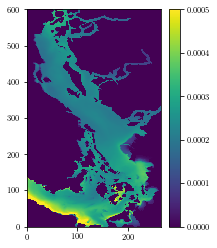

In [10]:
fig,ax=plt.subplots(1,1,figsize=(3,4))
m=ax.pcolormesh(np.mean(IPP,0),vmin=0,vmax=.0005)
fig.colorbar(m)

In [11]:
savepath

'/data/eolson/results/MEOPAR/SS36runs/calcFiles/NTransport/IPP_LD_noDisc_20150515-20150820.pkl'